In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision

In [20]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)
        
    def forward(self, X):
        X = X.view(X.size(0), -1)
        X = self.fc1(X)
        X = F.relu(X)
        X = self.fc2(X)
        X = F.relu(X)
        X = self.fc3(X)
        X = F.relu(X)
        X = self.fc4(X)
        return X


In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)),
])

In [5]:
train_dataset = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

In [6]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

In [7]:
for images, labels in train_loader:
    print(images.shape)  # [batch_size, 1, 28, 28]
    print(labels.shape)  # [batch_size]
    break


torch.Size([64, 1, 28, 28])
torch.Size([64])


In [8]:
# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

In [9]:
# plot some images

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_size = 28*28
hidden_size = 64
output_size = 10

model = MLP(input_size, hidden_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()  # works with raw logits
optimizer = torch.optim.SGD(model.parameters(), lr=0.03)


In [29]:
torch.__version__

'2.9.0+cu126'

In [22]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()   
     # Compute test accuracy
    model.eval()  # set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # disable gradient calculation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)  # get class with highest score
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Test Accuracy: {accuracy:.2f}%")


Epoch [1/10], Loss: 0.9036, Test Accuracy: 78.22%
Epoch [2/10], Loss: 0.4885, Test Accuracy: 79.17%
Epoch [3/10], Loss: 0.4310, Test Accuracy: 84.68%
Epoch [4/10], Loss: 0.3980, Test Accuracy: 85.42%
Epoch [5/10], Loss: 0.3761, Test Accuracy: 87.10%
Epoch [6/10], Loss: 0.3577, Test Accuracy: 85.23%
Epoch [7/10], Loss: 0.3423, Test Accuracy: 88.07%
Epoch [8/10], Loss: 0.3306, Test Accuracy: 88.72%
Epoch [9/10], Loss: 0.3203, Test Accuracy: 89.05%
Epoch [10/10], Loss: 0.3099, Test Accuracy: 89.23%


In [13]:
# Get one batch from validation_loader
images, labels = next(iter(test_loader))  # images shape: [batch_size, 1, 28, 28]

# Pick the first image in the batch
img = images[0].to(device).unsqueeze(0)  # add batch dimension: [1, 1, 28, 28]
true_label_idx = labels[0].item()


In [14]:
model.eval()  # evaluation mode
with torch.no_grad():  # no gradient computation
    logits = model(img)                  # raw outputs
    probs = torch.softmax(logits, dim=1) # probabilities
    pred_idx = torch.argmax(probs, dim=1).item()


In [15]:

pred_class = classes[pred_idx]
true_class = classes[true_label_idx]

print(f'True class: {true_class}')
print(f'Predicted class: {pred_class}, probability: {probs[0, pred_idx]:.4f}')


True class: Ankle Boot
Predicted class: Ankle Boot, probability: 0.9880


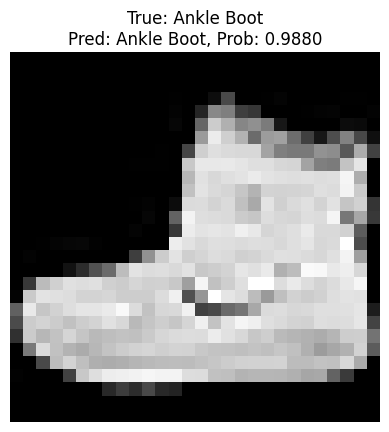

In [16]:
import matplotlib.pyplot as plt
import torch

# Get one batch from validation_loader
images, labels = next(iter(test_loader))

# Pick the first image
img = images[0].to(device).unsqueeze(0)  # add batch dimension: [1,1,28,28]
true_label_idx = labels[0].item()

# Forward pass
model.eval()
with torch.no_grad():
    logits = model(img)
    probs = torch.softmax(logits, dim=1)
    pred_idx = torch.argmax(probs, dim=1).item()

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Display the image
plt.imshow(images[0].squeeze(), cmap='gray')
plt.title(f"True: {classes[true_label_idx]}\nPred: {classes[pred_idx]}, Prob: {probs[0, pred_idx]:.4f}")
plt.axis('off')
plt.show()
